# Linear Optimal Control Problem

A general discrete-time dynamical system is $x(k+1) =f(x(k),u(k))$ and a linear dynamical system is $x(k+1) = Ax(k)+Bu(k)$ where $A,B$ are constant matrices. We want to know what is the minimum cost (or effort) to drive this system's trajectory from any initial point to the equilibrium. To this done, we define a stage cost, or the cost incurs at each state and input that helps to land in that state. The most common cost is quadratic stage cost: $l(u,x)= u^2+x^2$. Then total cost is:  $J(x_0,u) = \sum_{k=0}^{\infty} (x_k^Tq x_k + u_k^Tr u_k)$.

Since we are looking for the optimal cost, we need to find an optimal sequence of u(.) from all possible infinite sequences of u(.) that gives us minimum total cost. That is we find the value function: $V(k,x_0) = \min_{u(.)} \sum_{i=k}^{\infty} (x_i^Tq x_i + u_i^Tr u_i) $.

However, finding an optimal u(.) from all possible sequences of u(.) is impossible. Fortunately, we can use Bellman equation to perform an recursive calculation which can be approximated.
Dynamic programming principle: $V(k,x_0) = \min_{u} \big(x_0^T q x_0 + u^T r u + V(k+1,Ax_0+Bu)\big)$. So, instead of looking for entire sequence, we just looking for one input at one step that minimize the cost.

The core idea is we approximate the infinite sum by a finite sum of maximum time index K. Then, we can initilize value function at K and working backward to find value function at k=0. By doing this, we essentially ignore the tail (suming from K to $\infty$) that is we assume it is neglectable $\epsilon$.


** Goal ** Estimate value function $V$ for given initial state $x$. From that we can easily find input sequence that attains the minial cost.

In [47]:
import numpy as np
from matplotlib import pyplot as plt
import scipy
%matplotlib inline

## Data

In [48]:
A,B,q,r = 2,1,1,1

In [49]:
nbgp = 31;
nbip = 61;

In [50]:
x = np.linspace(-4,4,nbgp);
u = np.linspace(-10,10,nbip);

## 1. Solution via discrete-time Riccati Equation

**Assumption (only true for linear system and quadratic cost)**

$V(k+1,x_0) = x_0^TP(k+1)x_0$. 

Then, $V(k,x_0) = \min_u \big(x_0^Tqx_0 + u^Tru +(Ax_0+Bu)^T P(k+1)(Ax_0+Bu)\Big)$.

Solving the quadratic optimization problem by taking the derivative and set it to be zero
results in:

$u* = -(r+B^TP(k+1)B)^{-1}B^TP(k+1)Ax_0$.

Thus, plug the optimal value of $u*$ in original value function, after some algebraic manipulations, we end up with

$V(k,x_0) = x_0^T\Big(q+A^TP(k+1)A-A^TP(k+1)B(r+B^TP(k+1)B)^{-1}B^TP(k+1)A\Big)x_0 = x_0^TP(k)x_0$

which, in turn, implies

$P(k) = q+A^TP(k+1)A-A^TP(k+1)B(r+B^TP(k+1)B)^{-1}B^TP(k+1)A$


this equation is discrete-time Riccati equation which can be solved by initilizing $P(k+1)$ and recursively calculating $P(k)$.


In [51]:
def lqr_are(K,PK,A,B,r,q):
    P = np.zeros(K+1)
    P[K] = PK
    for i in range(K-1,-1,-1):
        P[i]=q+ A*P[i+1]*A - A*P[i+1]*B*1/(r + B*P[i+1]*B)*B*P[i+1]*A;
    return P

In [52]:
# Horizon
K = 20
# initialization at max time K
PK =10
P = lqr_are(K,PK,A,B,r,q)

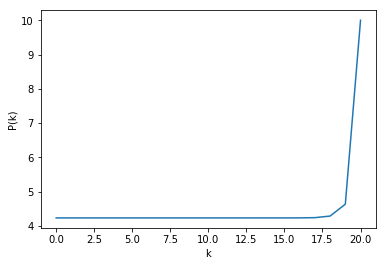

In [53]:
k = range(K+1)
plt.plot(k, P)
plt.xlabel('k')
plt.ylabel('P(k)')

Value function now is simply:

$V(k,x) = x^TP_{0} x$

where $P_0$ is value of $P$ calculated at time k=0.

In [54]:
V = np.zeros(len(x))
for i in range(len(x)):
    V[i] = x[i]*P[0]*x[i]

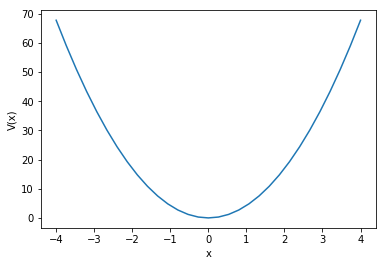

In [55]:
plt.plot(x, V)
plt.xlabel('x')
plt.ylabel('V(x)')

### Initialize different P(K) at the max time K

Let's see how the soltion behaves with different inilialized values.

In [56]:
def lqr_are(K,PK,A,B,r,q):
    P = np.zeros(K+1)
    P[K] = PK
    for i in list(range(K-1,-1,-1)):
        P[i]=q+ A*P[i+1]*A - A*P[i+1]*B*1/(r + B*P[i+1]*B)*B*P[i+1]*A;
    return P

In [57]:
P1 = lqr_are(K,1,A,B,r,q)
P2 = lqr_are(K,5,A,B,r,q)
P3 = lqr_are(K,10,A,B,r,q)
P4 = lqr_are(K,15,A,B,r,q)

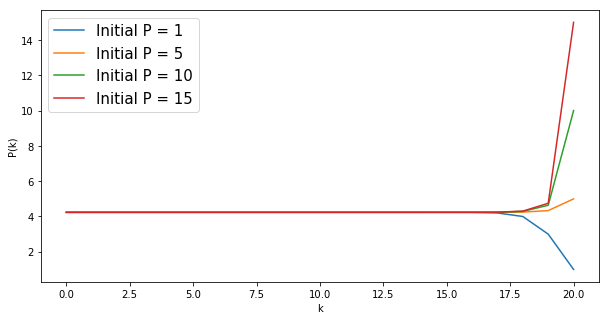

In [58]:
k = list(range(K+1))
plt.figure(figsize=(10,5)) 
plt.plot(k, P1,label="Initial P = 1")
plt.plot(k, P2,label="Initial P = 5")
plt.plot(k, P3,label="Initial P = 10")
plt.plot(k, P4,label="Initial P = 15")
plt.xlabel('k')
plt.ylabel('P(k)')
plt.legend(loc='upper left',prop={'size':15})

# 2. Approximate solution via dynamic programming

The DARE is nice, but we can only use it for linear system and quadratic cost. For general case, we can't assume that value function will take some quadratic form. Thus, we will need some way to calculate $V(k+1,f(x,u))$.


Core idea: Approximate the infinite series by a finite sum with a maximnum time index $K$.

Algorithms:

1. build a grid of state $x$ and time horizon $K$. 
2. initialize value function to be zero entire grid
3. recursively from K to 1:
   - calculate, for each grid node at layer k, the next value of state by the dynamic equation,i.e., x+
   - interpolate to get the value function at x+, i.e., V(x+)
   - calculate value function at previous layer k-1 by Bellman equation


Remmember Bellman equation:

$V(k,x_0) = \min_u \Big(loss(x,u) + V\big(k+1,f(x,u)\big)\Big)$.


In [59]:
# loss per step function
def loss(u,x,q,r):
    return q*np.array(x)**2+r*np.array(u)**2

In [60]:
def DP_LQR(K,VK,A,B,q,r):
    W = np.zeros([nbgp,K+1]) # Value grid
    W[:,K] = VK # Initialize value function at K 
    for i in list(range(K-1,-1,-1)):
        for j in range(len(x)):
            xp = A*x[j]+B*u;
            vi = np.interp(xp,x,W[:,i+1])
            W[j,i] = min(loss(x[j],u,q,r)+vi)   
    return W[:,0]

## Approximate solutions at different horizons

We look at different values of time horizons $K$ and compare the approximated solutions with the DARE solution.

In [61]:
# Different horizons
V_dp_2 = DP_LQR(2,0,A,B,q,r)
V_dp_5 = DP_LQR(5,0,A,B,q,r)
V_dp_20 = DP_LQR(20,0,A,B,q,r)

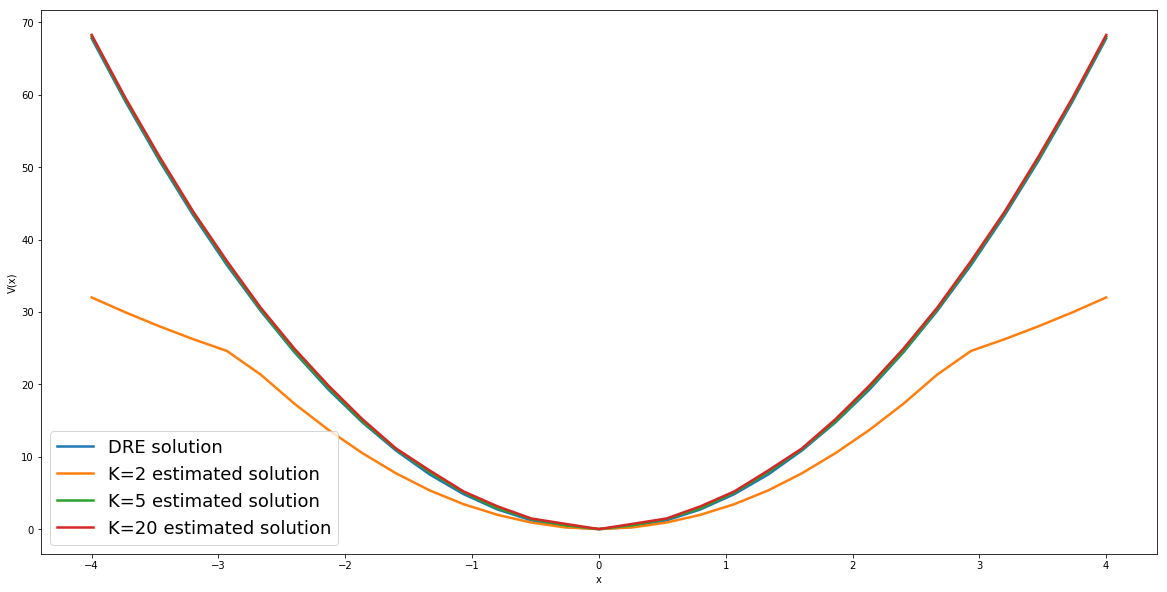

In [62]:
plt.figure(figsize=(20,10)) 
plt.plot(x, V,linewidth=2.5,label="DRE solution")
plt.plot(x, V_dp_2,linewidth=2.5,label="K=2 estimated solution")
plt.plot(x, V_dp_5,linewidth=2.5,label="K=5 estimated solution")
plt.plot(x, V_dp_20,linewidth=2.5,label="K=20 estimated solution")
plt.xlabel('x')
plt.ylabel('V(x)')
plt.legend(loc='lower left',prop={'size':18})

## Different interpolation methods
We look at different interpolation strategies and compare the approximated solutions with the DARE solution.

In [63]:
from scipy.interpolate import griddata
def DP_LQR_V(K,VK,A,B,q,r,method):
    W = np.zeros([nbgp,K+1]) # Value grid
    W[:,K] = VK # Initialize value function at K 
    for i in list(range(K-1,-1,-1)):
        for j in range(len(x)):
            xp = A*x[j]+B*u;
            vi = griddata(x,W[:,i+1],xp,method)
            W[j,i] = min(loss(x[j],u,q,r)+vi)   
    return W[:,0]

In [64]:
K=10
VK=0
W_nearest = DP_LQR_V(K,VK,A,B,q,r,'nearest')
W_linear = DP_LQR_V(K,VK,A,B,q,r,'linear')
W_cubic = DP_LQR_V(K,VK,A,B,q,r,'cubic')

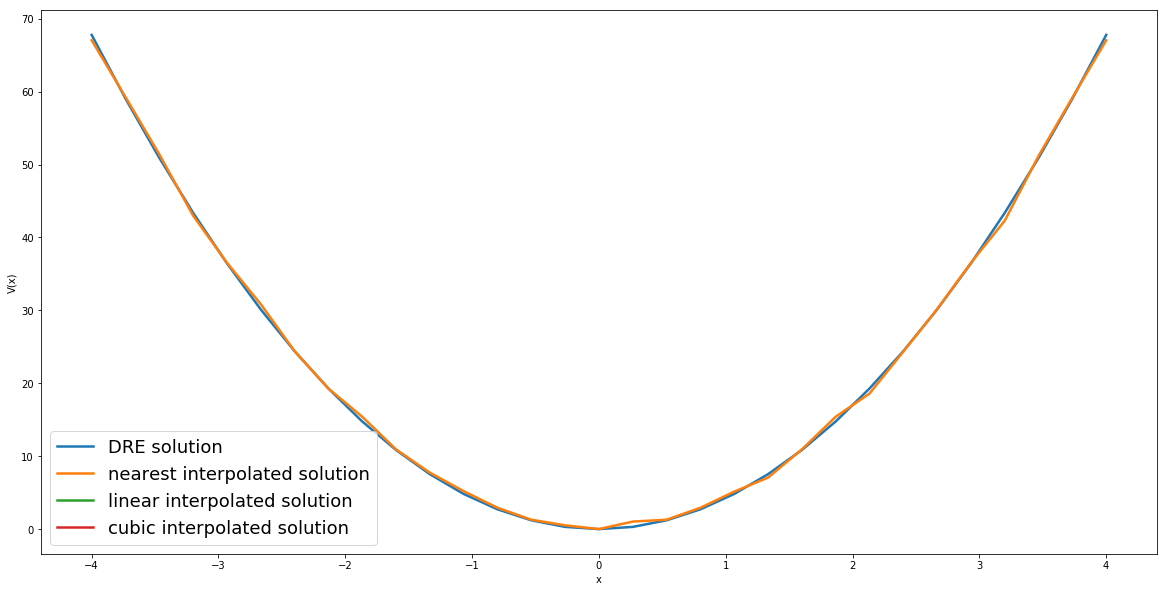

In [65]:
plt.figure(figsize=(20,10)) 
plt.plot(x, V,linewidth=2.5,label="DRE solution")
plt.plot(x, W_nearest,linewidth=2.5,label="nearest interpolated solution")
plt.plot(x, W_linear,linewidth=2.5,label="linear interpolated solution")
plt.plot(x, W_cubic,linewidth=2.5,label="cubic interpolated solution")
plt.xlabel('x')
plt.ylabel('V(x)')
plt.legend(loc='lower left',prop={'size':18})

## V evolving on the grid of x and K

We look at how value function $V$ evolves and converges on the grid of state x and time horizon $K$.

In [66]:
def DP_LQR_V(K,VK,A,B,q,r):
    W = np.zeros([nbgp,K+1]) # Value grid
    W[:,K] = VK # Initialize value function at K 
    for i in list(range(K-1,-1,-1)):
        for j in range(len(x)):
            xp = A*x[j]+B*u;
            vi = np.interp(xp,x,W[:,i+1])
            W[j,i] = min(loss(x[j],u,q,r)+vi)   
    return W

In [76]:
K=30
W = DP_LQR_V(K,0,A,B,q,r)

In [77]:
X, Y = np.meshgrid(range(K+1),x)

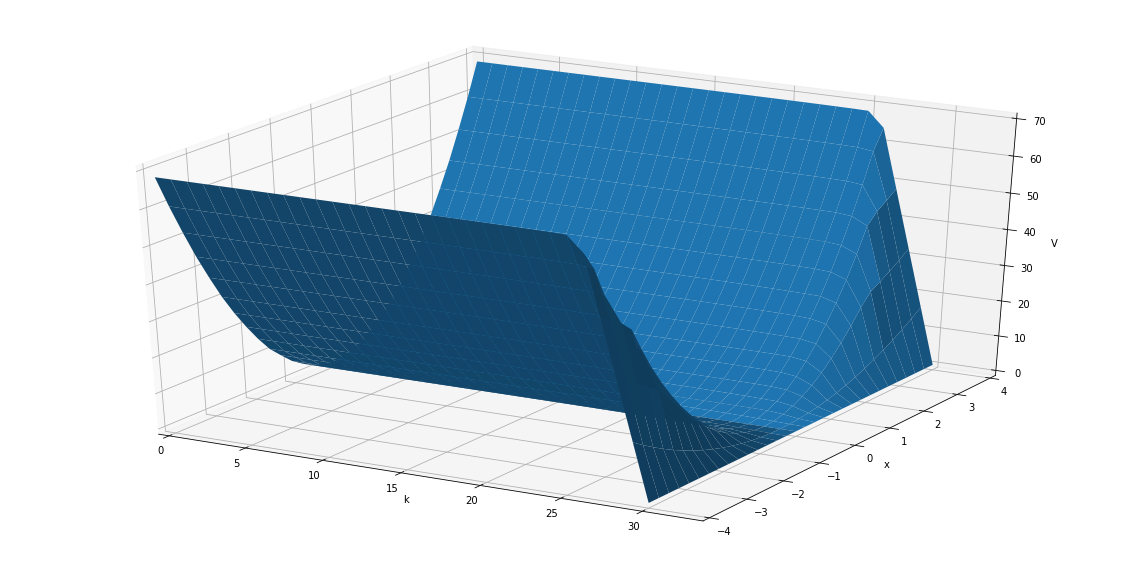

In [78]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, W)

ax.set_xlim(0,K+3)
ax.set_ylim(-4, 4)
ax.set_zlim(0, 70)

ax.set_xlabel('k')
ax.set_ylabel('x')
ax.set_zlabel('V')